In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

Задание 1. Работа с реальными данными

Напишите функции read_gff и read_bed6 для чтения соответствующих форматов. Они должны возвращать датафреймы как в примере (картинка Example1), но имена колонок можно сделать любыми.

In [2]:
def read_gff(path_to_gff_file):
    columns = ["chromosome", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
    gff_df = pd.read_csv(path_to_gff_file, sep="\t", names=columns, skiprows=1)
    return gff_df


def read_bed6(path_to_bed_file):
    columns = ["chromosome", "start", "end", "name", "score", "strand"]
    bed_df = pd.read_csv(path_to_bed_file, sep="\t", names=columns)
    return bed_df

In [3]:
gff_file = "rrna_annotation.gff"
df_gff = read_gff(gff_file)

bed_file = "alignment.bed"
df_bed = read_bed6(bed_file)

Колонка с атрибутами несёт слишком много избыточной информации и ей не удобно пользоваться, 
оставьте в ней только данные о типе рРНК одной короткой строкой (16S, 23S, 5S)


In [4]:
df_gff["attributes"] = df_gff["attributes"].apply(lambda x: re.split(r";|\s|=", x)[3])

Сделайте таблицу, где для каждой хромосомы (на самом деле это не хромосомы, а референсные геномы) 
показано количество рРНК каждого типа. Постройте barplot, отображающий эти данные (картинка rRNA_barplot)


RNA type       16S   23S    5S
chromosome                    
Reference_1    2.0   2.0   2.0
Reference_10   5.0   5.0   NaN
Reference_11   2.0   2.0   2.0
Reference_12   2.0   2.0   2.0
Reference_13   4.0   4.0   4.0
Reference_14   4.0   4.0   5.0
Reference_15   8.0   8.0   8.0
Reference_16   7.0   7.0   8.0
Reference_17   7.0   7.0   8.0
Reference_18   2.0   3.0   2.0
Reference_19   7.0   7.0   8.0
Reference_2    5.0   5.0   5.0
Reference_20  11.0  10.0  10.0
Reference_21   1.0   1.0   1.0
Reference_22   4.0   4.0   4.0
Reference_23   1.0   1.0   1.0
Reference_24   4.0   4.0   4.0
Reference_25   3.0   3.0   3.0
Reference_26   4.0   4.0   4.0
Reference_3    2.0   2.0   2.0
Reference_4    8.0  10.0   6.0
Reference_5    6.0   6.0   6.0
Reference_6    2.0   2.0   2.0
Reference_7    9.0   8.0   8.0
Reference_8    2.0   2.0   NaN
Reference_9    6.0   6.0   6.0


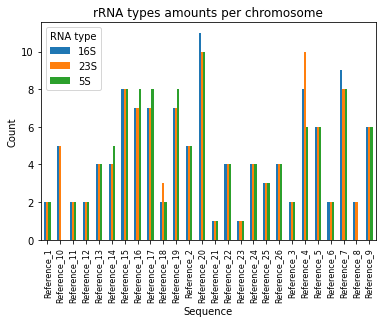

In [5]:
rrna_per_chr = pd.DataFrame({"count": df_gff.filter(["chromosome",
                                                     "attributes"], axis=1).groupby(["chromosome",
                                                                                     "attributes"]).size()}).reset_index()
rrna_per_chr = rrna_per_chr.rename({"attributes": "RNA type"}, axis='columns')
rrna_per_chr = pd.pivot(rrna_per_chr, index="chromosome", columns="RNA type", values="count")
print(rrna_per_chr)

barplot = rrna_per_chr.plot.bar()
plt.title("rRNA types amounts per chromosome")
plt.xlabel("Sequence")
plt.ylabel("Count")
plt.xticks(rotation=90, horizontalalignment="center", fontsize=8)
plt.show()



Далее самое интересное. Мы хотим узнать сколько рРНК в процессе сборки успешно собралось. 
Для этого можно воспользоваться программой bedtools intersect и пересечь эти два файла. В результате 
сохранятся только записи об рРНК, интервал которой перекрывался с интервалом контига в выравнивании, 
это означает, что это ген есть в сборке. Но забудьте про bedtools! У нас тут вообще-то пандас! 
Поэтому давайте получим такой же результат в нём. Выведите таблицу, содержащую исходные записи об рРНК 
полностью вошедших в сборку (не фрагментом), а также запись о контиге в который эта РНК попала. 
Обратите внимание, что в один контиг может попасть несколько рРНК.

In [6]:
columns_final = ["chromosome", "source", "type", "start", "end", "score", "strand", "phase", "attributes",
                 "contig_start", "contig_end", "contig_name"]
contigs_df = pd.DataFrame(columns=columns_final)


def get_intersection_table(rrna, contigs_bed):
    global contigs_df
    global columns_final
    contig = contigs_bed[(contigs_bed["start"] <= rrna["start"]) & (contigs_bed["end"] >= rrna["end"])].reset_index()
    contig = contig[["start", "end", "name"]]
    rows_number = contig.shape[0]
    df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
    rrna_contigs_total = pd.concat([df_rrna, contig], axis=1, ignore_index=True)
    rrna_contigs_total.columns = columns_final
    contigs_df = pd.concat([contigs_df, rrna_contigs_total], ignore_index=True)


df_gff.apply(lambda x: get_intersection_table(x, df_bed), axis=1)
contigs_df.to_csv("contigs_result.tsv", sep="\t")
contigs_df.head()

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df_rrna = pd.DataFrame(pd.np.tile(rrna, (rows_number, 1)))
<ipython-input-6-4307b4fac11e>:12: FutureWarning: The pandas.np module is deprec

,chromosome,source,type,start,end,score,strand,phase,attributes,contig_start,contig_end,contig_name
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S,0,77182,NODE_167_length_129512_cov_538.696100
1,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S,0,128866,NODE_158_length_133586_cov_762.631164
2,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S,43303,182787,NODE_147_length_139481_cov_489.044181
3,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S,28509,79045,NODE_409_length_50774_cov_71.880380
4,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S,22013,89527,NODE_320_length_67436_cov_707.250560


**Задание 2. Кастомизация графиков**

В данном задании вам нужно максимально точно воспроизвести график volcano_plot.png (прикреплён к заданию). 
Для этого используйте файл с данными diffexpr_data.tsv.gz (пандас умеет открывать .gz файлы, поэтому разжимать 
их не обязательно). Данные уже предобработаны, считать p-value и брать логарифмы уже не надо, 
просто используйте колонки logFC и log_pval. Если необходимо, можете делать группировку данных 
или брать subsets, но в итоге на графике должны быть именно значения из этих колонок. 
Ниже приведён чеклист кастомизаций для удобства, чем больше вы сделаете, тем лучше.


In [7]:
def get_regulation(sample):
    if sample["log_pval"] <= 1.301 and sample["logFC"] < 0:
        return "Non-significantly downregulated"
    elif sample["log_pval"] > 1.301 and sample["logFC"] < 0:
        return "Significantly downregulated"
    elif sample["log_pval"] <= 1.301 and sample["logFC"] >= 0:
        return "Non-significantly upregulated"
    else:
        return "Significantly upregulated"

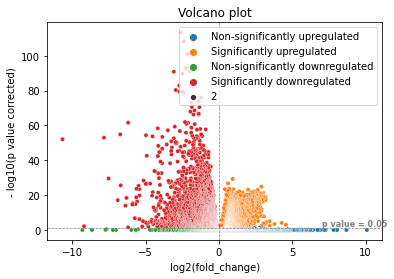

In [14]:
%matplotlib inline

rna_data = pd.read_csv("diffexpr_data.tsv", sep="\t")
rna_data["regulation"] = rna_data.apply(lambda x: get_regulation(x), axis=1)
rna_data.to_csv("rna_data.tsv", sep="\t")

plot = sns.scatterplot(x="logFC", y="log_pval", data=rna_data, hue="regulation", size=2, legend="brief")
plt.setp(plot.get_legend().get_texts(), fontsize=8)
plot.text(7, 2, "p value = 0.05", color='grey', fontsize=8, fontweight='bold')
fig = plot.figure
plt.rcParams["figure.figsize"] = [30, 20]
plt.title("Volcano plot")
plt.xlabel("log2(fold_change)")
plt.ylabel("- log10(p value corrected)")
plt.axvline(0, color="grey", linestyle="--", linewidth=0.7)
plt.axhline(1.301, color="grey", linestyle="--", linewidth=0.7)
plt.legend(loc='upper right')
plt.show()